# Notebook for optimising HCRv3 analysis parameters
## Stripped down version of smFISH analysis (removed cluster decomposition elements)
## Using Big-fish v0.6.2
## Revised: 2023.05.22
1. Optimise Bigfish parameters for a single image
2. The set parameters should then be used for batch processing

In [1]:
import os
import time

from skimage.morphology import white_tophat, black_tophat, disk
from scipy import ndimage, misc
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import pandas as pd

import bigfish
import bigfish.stack as stack
import bigfish.multistack as multistack 
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.detection as detection

print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


/Users/jefflee/Documents/Github/bigfish-pypeline/.pixi/envs/default/lib/python3.9/site-packages/bigfish/segmentation/nuc_segmentation.py:16: FutureWarning: The `skimage.morphology.selem` module is deprecated and will be removed in scikit-image 1.0 (`skimage.morphology.selem` has been moved to `skimage.morphology.footprints`).
  from skimage.morphology.selem import disk


# 0. Load Bigfish helper functions

In [2]:
## Calculate PSF (thanks MK!!)
def calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope):
    if microscope == 'widefield':
        psf_yx = 0.225*Em/NA
        psf_z = 0.78*RI*Em/(NA**2)
    elif microscope in {'confocal', 'nipkow'}:
        psf_yx = 0.225/NA*Ex*Em/np.sqrt(Ex**2 + Em**2)
        psf_z = 0.78*RI/NA**2*Ex*Em/np.sqrt(Ex**2 + Em**2)
    else:
        print(f'microscope={microscope} is not a valid option')
        sys.exit()
    return psf_z, psf_yx

## Subtract background
def subtract_background(image, radius=5, light_bg=False):
    str_el = disk(radius) #you can also use 'ball' here to get a slightly smoother result at the cost of increased computing time
    if light_bg:
        return black_tophat(image, str_el)
    else:
        return white_tophat(image, str_el)

# 1. Import image and its metadata

In [3]:
# Import image file
file_name = '/Users/jefflee/Desktop/FISH-01_4h_17_bsub50.tif'
img = tifffile.imread(file_name)

print("Image imported: ", file_name)
print("\r shape: {0}".format(img.shape))
print("\r dtype: {0}".format(img.dtype))

# Set up image acquisition parameters
chan = 3
voxel_size_z = 200
voxel_size_yx = 65
Ex = 570
Em = 610
NA = 1.45
RI = 1.45
microscope = 'confocal'

psf_z = calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope)[0]
psf_yx = calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope)[1]

spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=(voxel_size_z, voxel_size_yx, voxel_size_yx), 
    object_radius_nm=(psf_z, psf_yx, psf_yx), 
    ndim = 3)

print(" ")
print("PSF and Sigma calculation finished")
print("\r theoretical psf_z = ", psf_z)
print("\r theoretical psf_yx = ", psf_yx)
print("\r spot radius (sigma_z) (z axis): {:0.3f} pixels".format(spot_radius_px[0]))
print("\r spot radius (sigma_yx) (yx plan): {:0.3f} pixels".format(spot_radius_px[-1]))

Image imported:  /Users/jefflee/Desktop/FISH-01_4h_17_bsub50.tif
 shape: (33, 4, 2048, 2048)
 dtype: uint16
 
PSF and Sigma calculation finished
 theoretical psf_z =  224.03449989716577
 theoretical psf_yx =  64.62533650879783
 spot radius (sigma_z) (z axis): 1.120 pixels
 spot radius (sigma_yx) (yx plan): 0.994 pixels


# 2. Optimise bigfish parameters
## 2-1. Get LoG filtred RNA channel image for pre-detection thresholding

In [4]:
# Background subtract RNA image and LoG filter
start_time = time.time()

# Channel subset original image
rna = np.swapaxes(img,0,1)[chan]

print("Image shape ")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

# MIP image for plotting later or for 2D detection
rna_mip = stack.maximum_projection(rna)

# Background subtract
rna_no_bg = []
for z in rna:
    z_no_bg = subtract_background(z)
    rna_no_bg.append(z_no_bg)
rna = np.array(rna_no_bg)

print ("Background subtraction finished ", time.time() - start_time, "sec")

# LoG filter
rna_log = stack.log_filter(rna, sigma = spot_radius_px)
print ("LoG filter finished ", time.time() - start_time, "sec")

# Export LoG filtered image to the working directory
rna_log_max = np.max(rna_log, 0)
Image.fromarray(rna_log_max).save('rna_log.tif')

print ("Image saved to working dir! Open it on ImageJ! ", time.time() - start_time, "sec")


Image shape 
 shape: (33, 2048, 2048)
 dtype: uint16
Background subtraction finished  12.752797842025757 sec
LoG filter finished  40.36130690574646 sec
Image saved to working dir! Open it on ImageJ!  40.54226994514465 sec


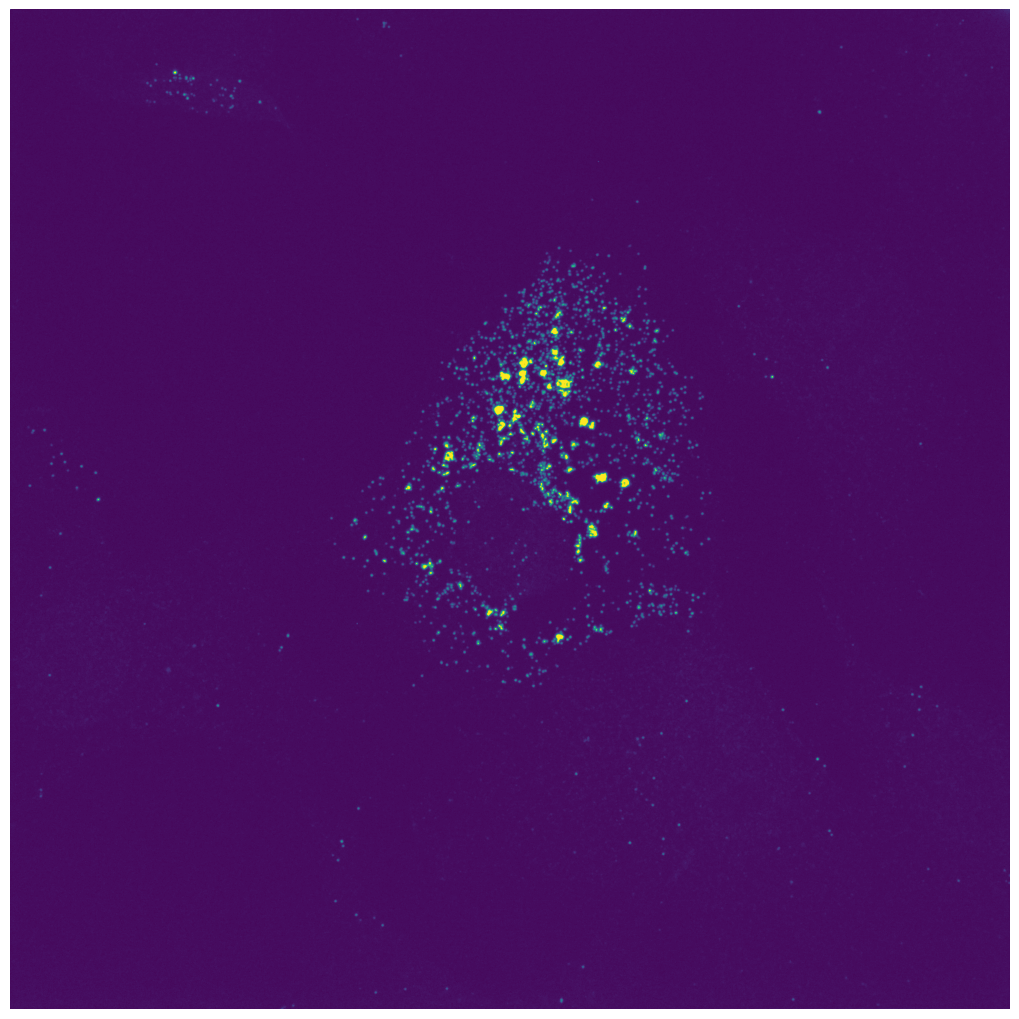

In [12]:
plot.plot_images(rna_mip, contrast=True)

## 2-2 Optimise single-spot detection

### Option 1 - Manual thresholding

pre-detection done
threshold done 7.9467339515686035 sec
detected spots
 shape: (2398, 3)
 dtype: int64
 threshold: 8


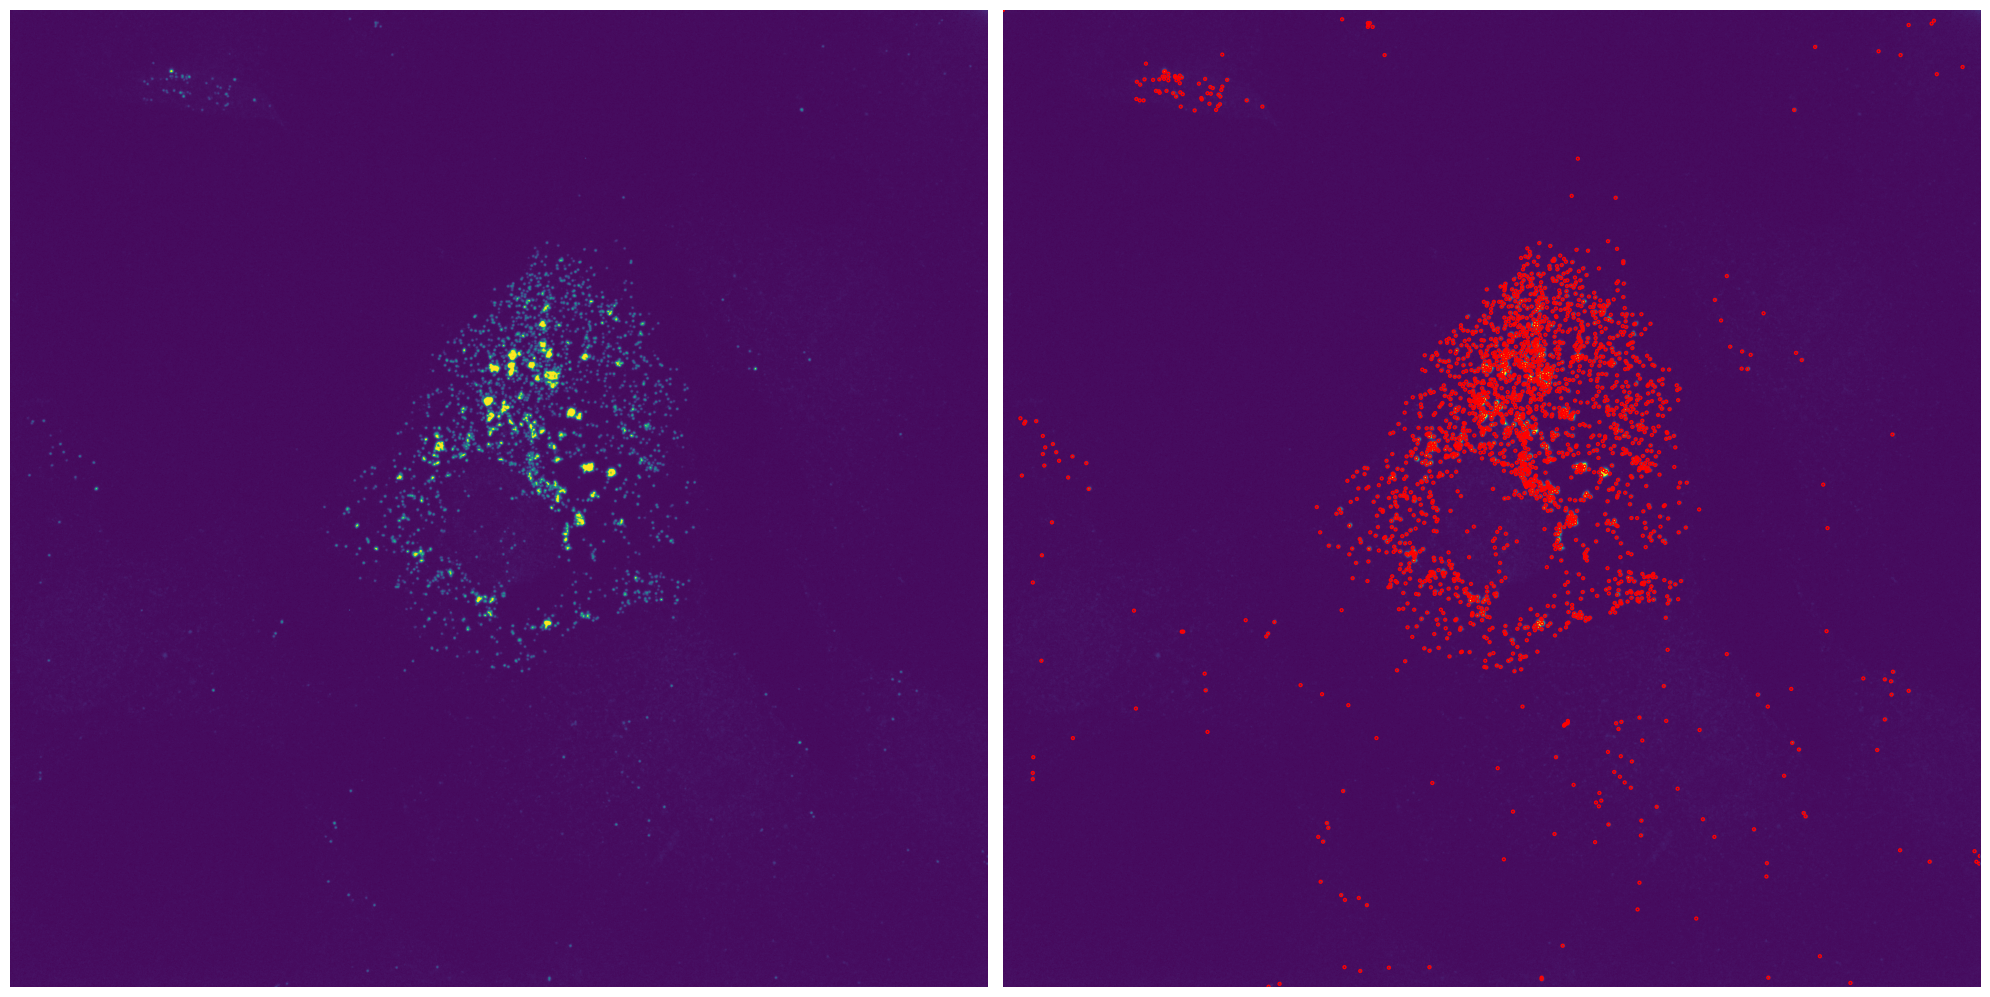

Plotting done  13.773559093475342 sec


In [5]:
start_time = time.time()

## local maximum detection
mask = detection.local_maximum_detection(rna_log, min_distance = spot_radius_px)
print ('pre-detection done')

## thresholding
threshold = 8
spots, _ = detection.spots_thresholding(rna_log, mask, threshold)
print ('threshold done', time.time() - start_time, "sec")

print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

## Plot detected spots
plot.plot_detection(rna_mip, spots, radius = 3, framesize = (20, 16), contrast = True)
print ("Plotting done ", time.time() - start_time, "sec")


### Option 2 - Auto-thresholding

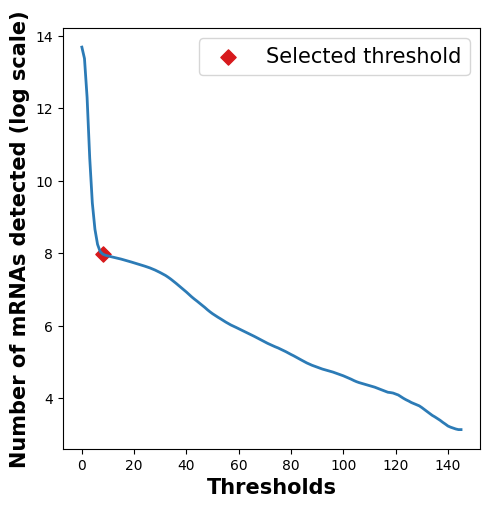

Elbow plot done  73.58470296859741 sec
Auto-threshold value found 76.22492980957031 sec
 threshold: 8.0
threshold done 77.72294282913208 sec
detected spots
 shape: (2398, 3)
 dtype: int64
 threshold: 8.0


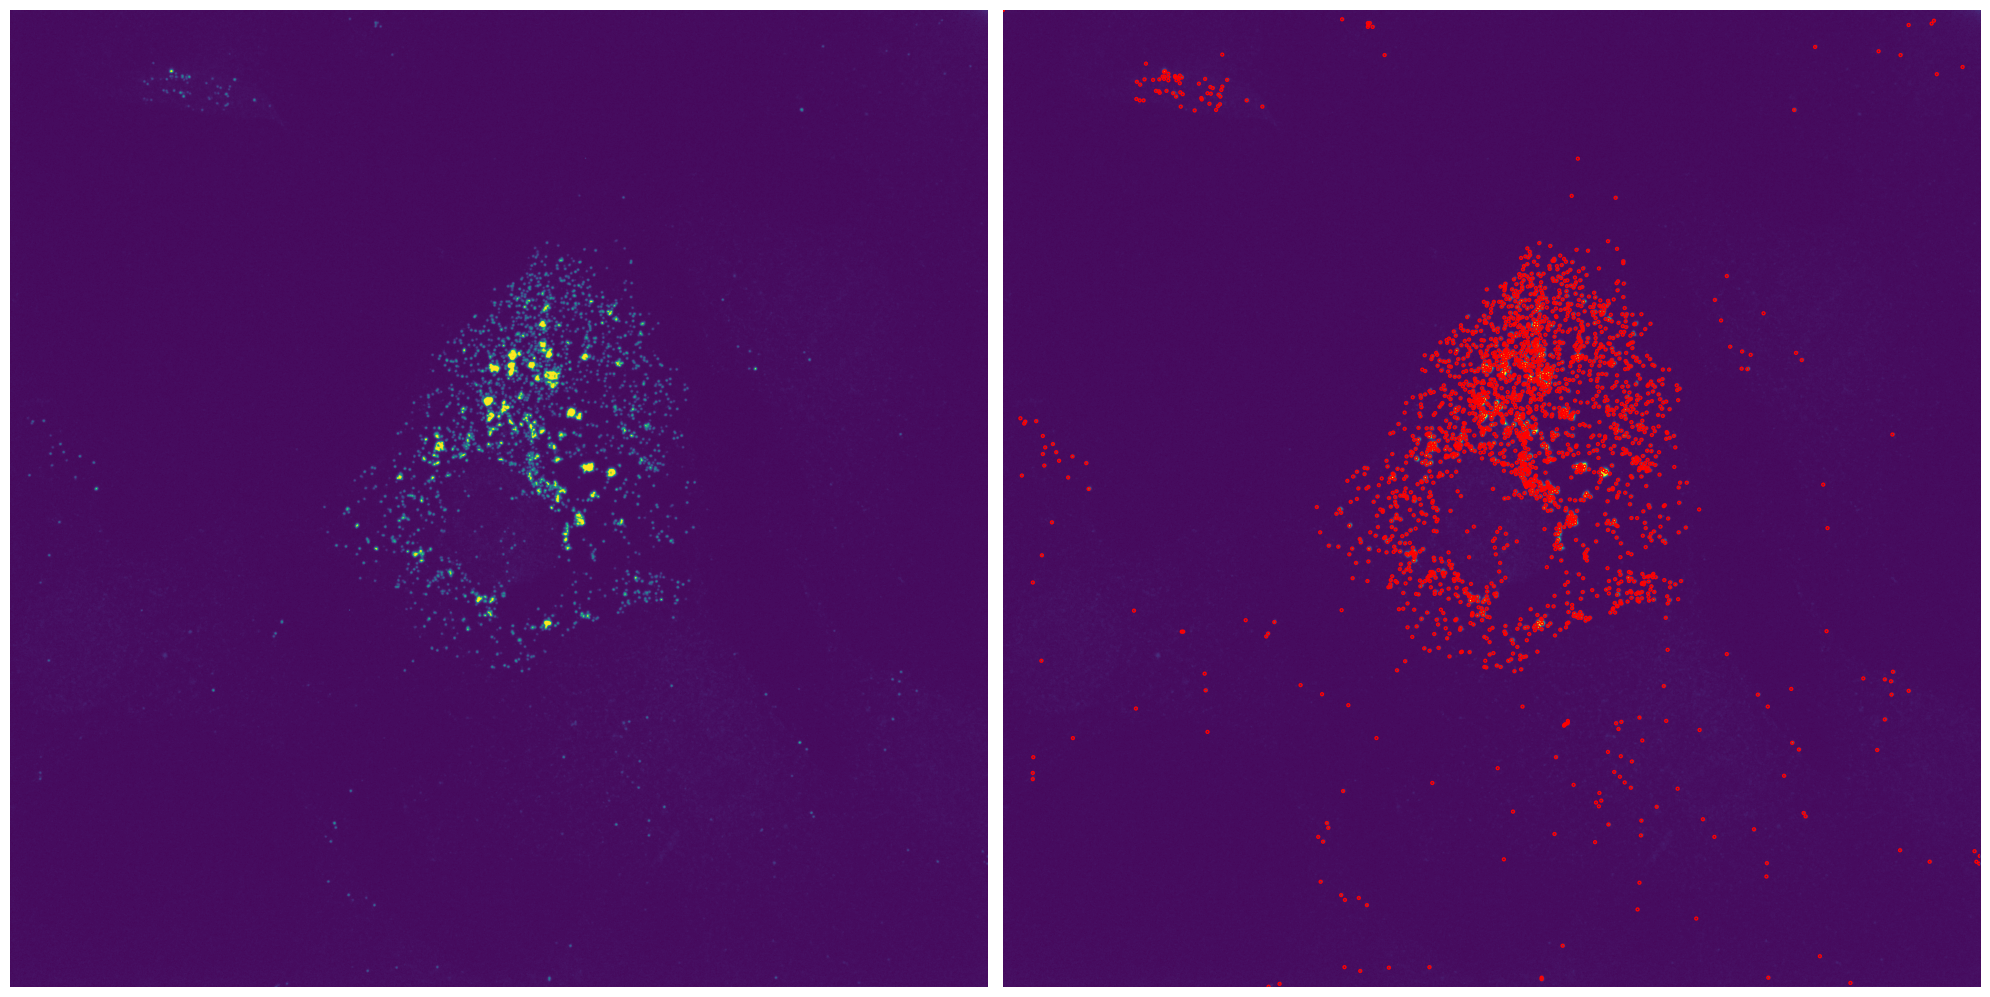

Plotting done  84.19458889961243 sec


In [15]:
start_time = time.time()

## local maximum detection
mask = detection.local_maximum_detection(rna_log, min_distance = spot_radius_px)
print ('pre-detection done')

## Get Elbow plot
plot.plot_elbow(
    rna,
    voxel_size = (voxel_size_z, voxel_size_yx, voxel_size_yx),
    spot_radius = (psf_z, psf_yx, psf_yx)
)
print ("Elbow plot done ", time.time() - start_time, "sec")

## Get autothreshold value
threshold_auto = detection.automated_threshold_setting(rna_log, mask)
print("Auto-threshold value found", time.time() - start_time, "sec")
print("\r threshold: {0}".format(threshold_auto))

## thresholding (automated)
spots, _ = detection.spots_thresholding(rna_log, mask, threshold_auto)
print ('threshold done', time.time() - start_time, "sec")

print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold_auto))

## Plot detected spots
plot.plot_detection(rna_mip, spots, radius = 3, framesize = (20, 16), contrast = True)
print ("Plotting done ", time.time() - start_time, "sec")

## 2-3. Optional - subpixel fitting 

In [ ]:
## - - - - - Subpixel fitting mode can be turned on or off in batch processing via yaml

start_time = time.time()

## Subpixel fitting
spots_post_subpixel = detection.fit_subpixel(
    image = rna,
    spots = spots,
    voxel_size = (voxel_size_z, voxel_size_yx, voxel_size_yx),
    spot_radius = (psf_z, psf_yx, psf_yx)
)
print(" ")
print("Subpixel fitting done ", time.time() - start_time, "sec","\n")
print("spots (subpixel fitted)")
print("\r shape: {0}".format(spots_post_subpixel.shape))
print("\r dtype: {0}".format(spots_post_subpixel.dtype), "\n")
print(spots_post_subpixel)

## Plot
plot.plot_detection(
    rna_mip, 
    spots=[spots, spots_post_subpixel], 
    radius=3, 
    color=["red", "blue"],
    title="Red = pixel fitting | Blue = subpixel fitting",
    linewidth = 1, contrast = True, framesize = (50, 40))

print ("Plotting done ", time.time() - start_time, "sec")

## 2-4. Move on to batch processing